In [ ]:
# Goals: to find 800 repository and get ML to classify its language

# ACQUIRE

In [1]:
# import
import requests
import json
from bs4 import BeautifulSoup

In [2]:
# set up API request headers
from env import github_token, github_username

headers = {
    "Authorization": f"token {github_token}",
    "User-Agent": github_username
}

In [3]:
# make API requests to get repository names
language = "python"
api_url = f"https://api.github.com/search/repositories?q=language:{language}&sort=stars&order=desc&per_page=100"
response = requests.get(api_url, headers=headers)

if response.status_code == 200:
    repositories = response.json()["items"]
else:
    print(f"Failed to fetch repository list. Status code: {response.status_code}")
    exit()

Goal: add all these results to a list, then find a way to go through and request another 10 results with always adding them to a list. clean up emphasis text from entries

In [4]:
import requests
import json
from env import github_token, github_username

# Define the headers with your token and username
headers = {
    "Authorization": f"token {github_token}",
    "User-Agent": github_username
}

# Define a function to get repositories based on a query and page
def get_repositories(query, sort="stars", order="desc", page=1):
    base_url = "https://api.github.com/search/repositories"
    params = {
        "q": query,
        "sort": sort,
        "order": order,
        "per_page": 10,  # You can get up to 100 results per page.
        "page": page  # Specify the page number
    }
    response = requests.get(base_url, headers=headers, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        return None

# Search for breast cancer related repositories and handle pagination
query = "breast cancer"
page = 1

# Create a list to collect the repository data
repository_data = []

while page <= 10:
    response_json = get_repositories(query, page=page)
    if response_json is None:
        print(f"Failed to fetch page {page} of repositories.")
        break

    # Extract and collect repository names
    for repo in response_json["items"]:
        repository_data.append({
            "full_name": repo["full_name"]
        })

    # Check if there are more pages
    if "Link" in response.headers:
        next_link = response.headers["Link"]
        if 'rel="next"' not in next_link:
            break
    else:
        break
    page += 1


In [5]:
# ... (Previous code remains the same)

# Extract only the repository names from the dictionaries
repository_names = [repo_data["full_name"] for repo_data in repository_data]

# Save the repository names list to a JSON file
with open("breast_cancer_repository.json", "w") as json_file:
    json.dump(repository_names, json_file, indent=2)

print("Data saved to breast_cancer_repository.json")


Data saved to breast_cancer_repository.json


In [6]:
import pandas as pd
df = pd.read_json('github_data.json')
df.shape

(200, 3)

# Prep phase

In [7]:
import unicodedata
import re
import json


import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords





In [8]:
import wrangle as w

In [9]:
df['clean_norm_token'] = df.readme_contents.apply(w.tokenize).apply(w.basic_clean).apply(w.remove_stopwords).apply(w.lemmatize)

# tokenizes, cleans, remove stopwprds, lemmatize the text in the readme_contents and 
# stores the processed text in a new column clean_norm_token
# extra steps were taken to 
df.clean_norm_token = df.clean_norm_token.str.replace('124', '')
df
# it removes any occurences of the string '124' from the clean_norm_token column

,repo,language,readme_contents,clean_norm_token
0,/nyukat/breast_cancer_classifier,Jupyter Notebook,# Deep Neural Networks Improve Radiologists' P...,deep neural network improve radiologist ' perf...
1,/lishen/end2end-all-conv,Jupyter Notebook,Shield: [![CC BY-NC-SA 4.0][cc-by-nc-sa-shield...,shield cc byncsa 40 ccbyncsashield ccbyncsa wo...
2,/ImagingLab/ICIAR2018,Python,# ICIAR2018\n### Two-Stage Convolutional Neura...,iciar2018 twostage convolutional neural networ...
3,/Jean-njoroge/Breast-cancer-risk-prediction,Jupyter Notebook,# Breast-cancer-risk-prediction\n\n> Necessity...,breastcancerriskprediction necessity mother in...
4,/abhinavsagar/breast-cancer-classification,Jupyter Notebook,# Breast-cancer-classification\n\nBreast Cance...,breastcancerclassification classification usin...
...,...,...,...,...
195,/mathcom/CPR,Python,# Improved prediction of breast cancer outcome...,improved prediction outcome identifying hetero...
196,/nihaomiao/PRICAI18_MVF-CasCNN,Python,MVF-CasCNN\n====\n\nThe Tensorflow implementat...,mvfcascnn tensorflow implementation pricai18 p...
197,/srihari2761/breast_cancer,Jupyter Notebook,# breast_cancer\nBreast cancer detection using...,breastcancer detection using cnn transfer lear...
198,/lthhieu/breast-cancer,Jupyter Notebook,# breast-cancer\nonly 6.5 ...\n,breastcancer 65


In [10]:
df.language.value_counts()

Python              85
Jupyter Notebook    78
R                   11
HTML                 4
Matlab               4
C#                   3
MATLAB               3
TeX                  2
Dart                 2
Objective-C          1
Lua                  1
Java                 1
Name: language, dtype: int64

In [11]:
# List of languages to combine into "Other"
languages_to_combine = ['Jupyter Notebook', 'MATLAB', 'TeX', 'C#', 'Matlab', 'Objective-C', 'Dart', 'Lua', 'Java']

# Replace the specified languages with "Other"
# by doing this we will have top 3 language used and 'other'

df['language'] = df['language'].replace(languages_to_combine, 'other')
df

,repo,language,readme_contents,clean_norm_token
0,/nyukat/breast_cancer_classifier,other,# Deep Neural Networks Improve Radiologists' P...,deep neural network improve radiologist ' perf...
1,/lishen/end2end-all-conv,other,Shield: [![CC BY-NC-SA 4.0][cc-by-nc-sa-shield...,shield cc byncsa 40 ccbyncsashield ccbyncsa wo...
2,/ImagingLab/ICIAR2018,Python,# ICIAR2018\n### Two-Stage Convolutional Neura...,iciar2018 twostage convolutional neural networ...
3,/Jean-njoroge/Breast-cancer-risk-prediction,other,# Breast-cancer-risk-prediction\n\n> Necessity...,breastcancerriskprediction necessity mother in...
4,/abhinavsagar/breast-cancer-classification,other,# Breast-cancer-classification\n\nBreast Cance...,breastcancerclassification classification usin...
...,...,...,...,...
195,/mathcom/CPR,Python,# Improved prediction of breast cancer outcome...,improved prediction outcome identifying hetero...
196,/nihaomiao/PRICAI18_MVF-CasCNN,Python,MVF-CasCNN\n====\n\nThe Tensorflow implementat...,mvfcascnn tensorflow implementation pricai18 p...
197,/srihari2761/breast_cancer,other,# breast_cancer\nBreast cancer detection using...,breastcancer detection using cnn transfer lear...
198,/lthhieu/breast-cancer,other,# breast-cancer\nonly 6.5 ...\n,breastcancer 65


In [12]:
df.language.value_counts().head(4)

other     95
Python    85
R         11
HTML       4
Name: language, dtype: int64

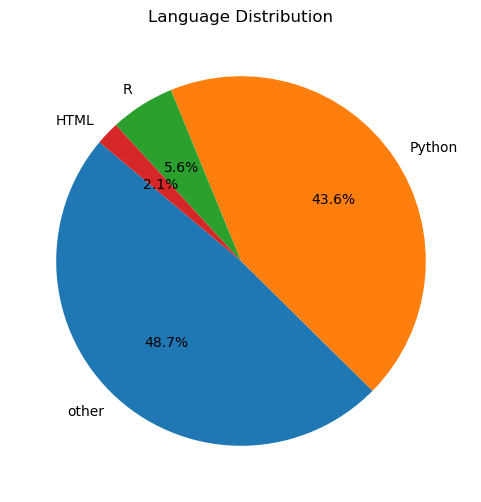

In [13]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame

# Get the value counts for the 'language' column
language_counts = df['language'].value_counts().head(4)

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(language_counts, labels=language_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Language Distribution')
plt.show()


# Exploration

In [14]:
import re
import unicodedata
import pandas as pd
import nltk

In [34]:
word_counts = {}  # Define word_counts as an empty dictionary

# Iterate through each unique language in your DataFrame
for language in df['language'].unique():
    # Filter the DataFrame for the specific language
    language_df = df[df['language'] == language]
    
    # Combine all tokenized text for the language and split it into words
    words = ' '.join(language_df['clean_norm_token']).split()
    
    # Count the words and store the count in the dictionary
    word_counts[language] = len(words)

# Create a DataFrame from the word counts dictionary
word_counts_df = pd.DataFrame(word_counts.items(), columns=['language', 'word_count'])

# Display the word counts
print(word_counts_df)
transposed_df = word_counts_df.transpose()
print(transposed_df)

  language  word_count
0    other       21831
1   Python       22980
2        R        1882
3     None           0
4     HTML         476
                0       1     2     3     4
language    other  Python     R  None  HTML
word_count  21831   22980  1882     0   476


### Word cloud 

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

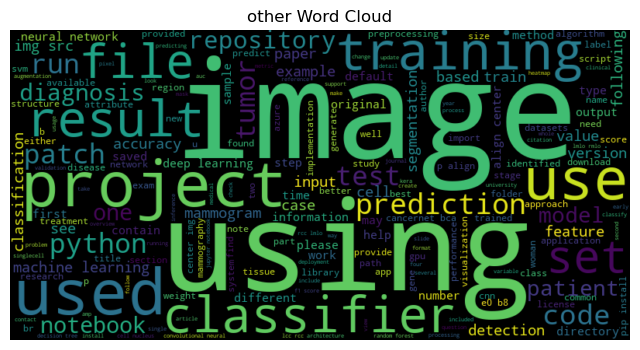

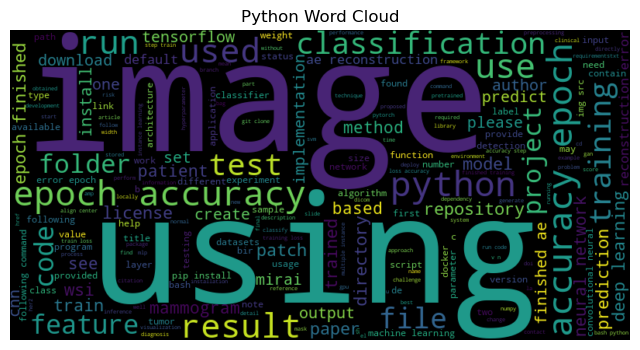

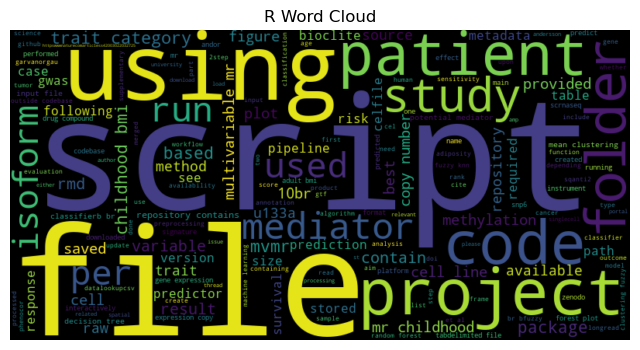

No words to generate a word cloud for None


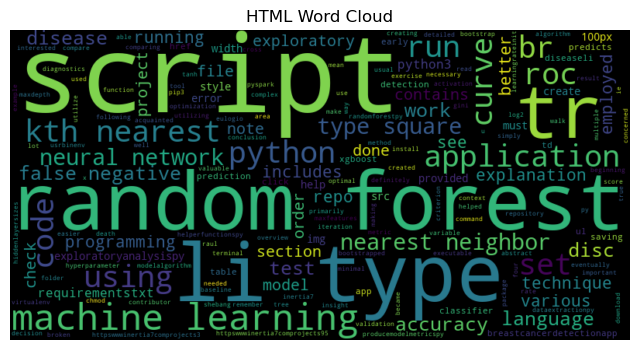

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Iterate through each unique language in your DataFrame
for language in df['language'].unique():
    # Filter the DataFrame for the specific language
    language_df = df[df['language'] == language]

    # Combine all tokenized text for the language and split it into words
    words = ' '.join(language_df['clean_norm_token']).split()

    # Check if there are words to generate a word cloud from
    if len(words) > 0:
        # Convert the list of words into a single string
        words_text = ' '.join(words)

        # Create a word cloud for the language
        wordcloud = WordCloud(width=800, height=400).generate(words_text)

        # Plot the word cloud
        plt.figure(figsize=(8, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'{language} Word Cloud')
        plt.axis('off')
        plt.show()
    else:
        print(f'No words to generate a word cloud for {language}')


If there are any results that are too similar between more than 2 tables, I will return to wrangle file and add in stopword under remove_stopwords function. Extra steps has been taken to remove common medical terminology as well as redundant technical terminology

From this visualization I can see a few things 
* the word dataset have a relationship with Python
* the word script have a relationship with HTML
* the word have a relationship with R
* the word have a relationship with other languages

# Bigram

In [19]:
from nltk.util import bigrams
import pandas as pd

In [21]:
# Define bigram_counts as an empty dictionary
bigram_counts = {}

# Iterate through each unique language in your DataFrame
for language in df['language'].unique():
    # Filter the DataFrame for the specific language
    language_df = df[df['language'] == language]
    
    # Combine all tokenized text for the language and split it into words
    words = ' '.join(language_df['clean_norm_token']).split()
    
    # Create bigrams from the words
    bigram_list = list(bigrams(words))
    
    # Count the bigrams and store the count in the dictionary
    bigram_counts[language] = len(bigram_list)

# Create a DataFrame from the bigram counts dictionary
bigram_counts_df = pd.DataFrame(bigram_counts.items(), columns=['language', 'bigram_count'])

# Display the bigram counts
print(bigram_counts_df)
transposed_df = bigram_counts_df.transpose()
print(transposed_df)

  language  bigram_count
0    other         21830
1   Python         22979
2        R          1881
3     None             0
4     HTML           475
                  0       1     2     3     4
language      other  Python     R  None  HTML
bigram_count  21830   22979  1881     0   475


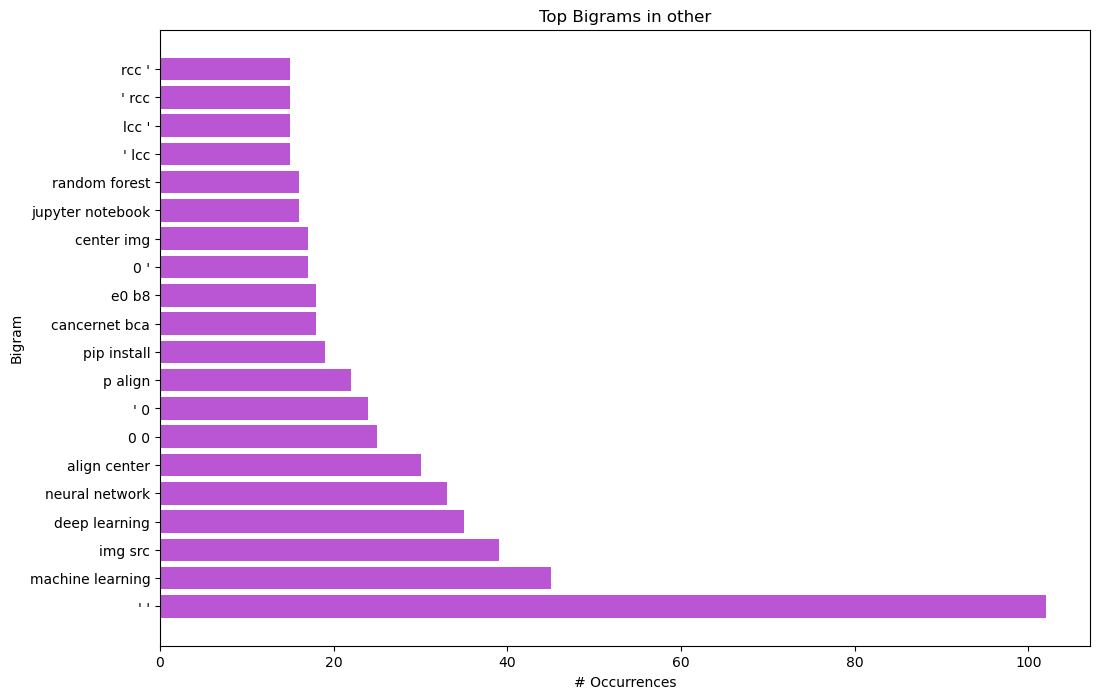

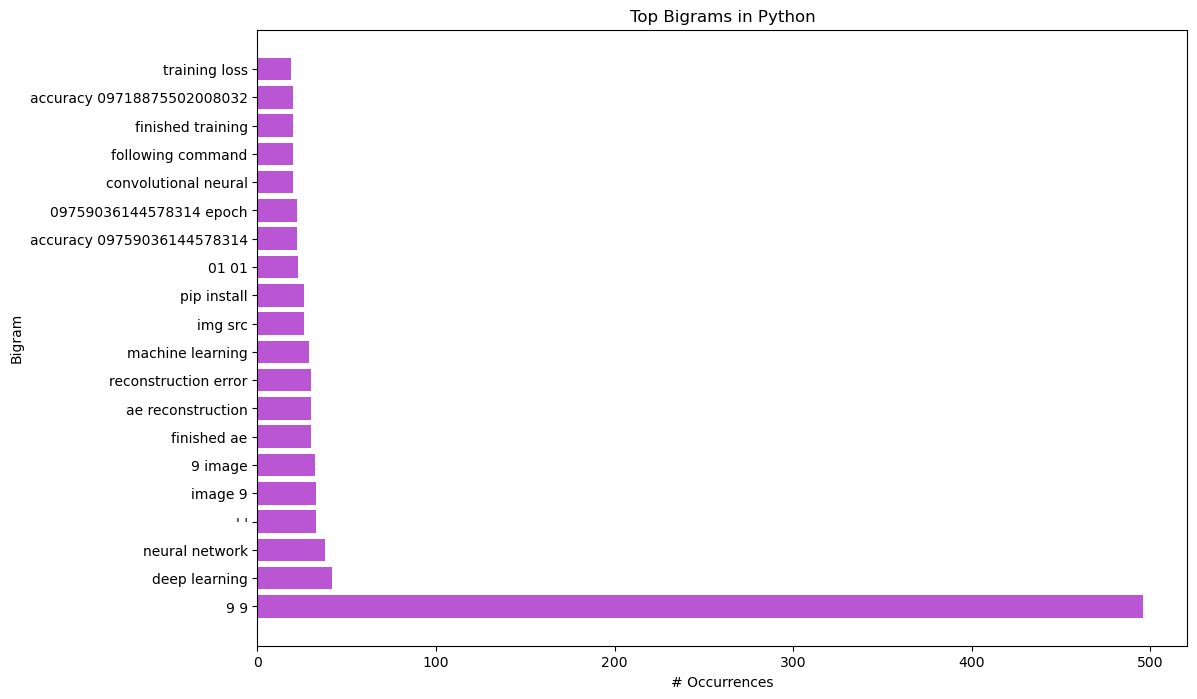

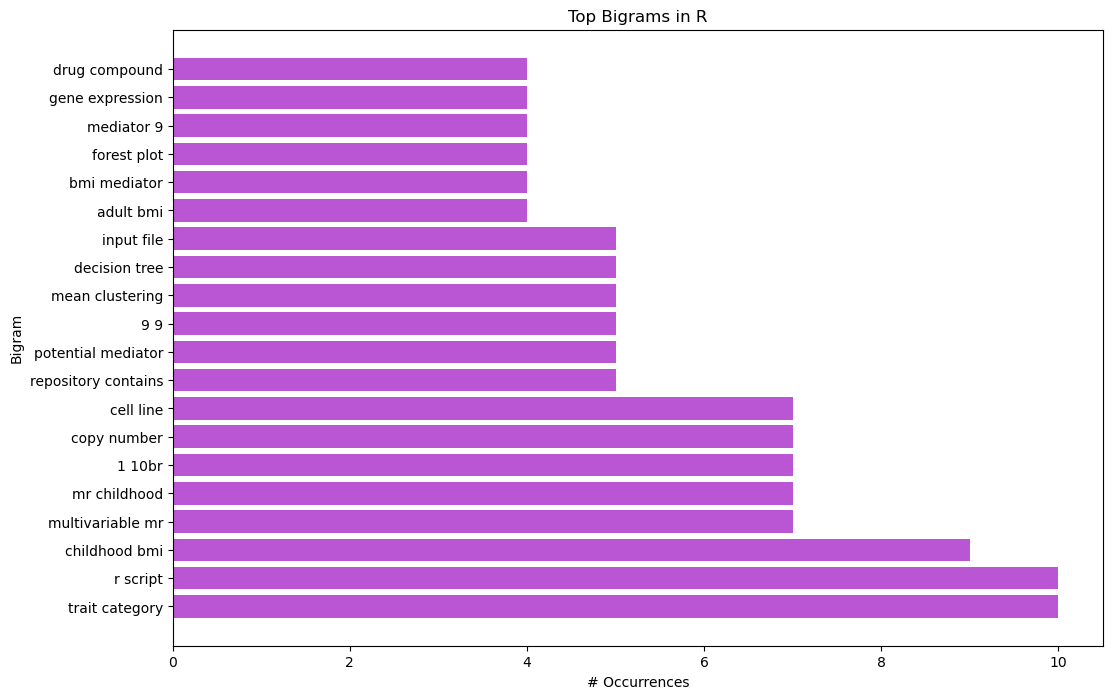

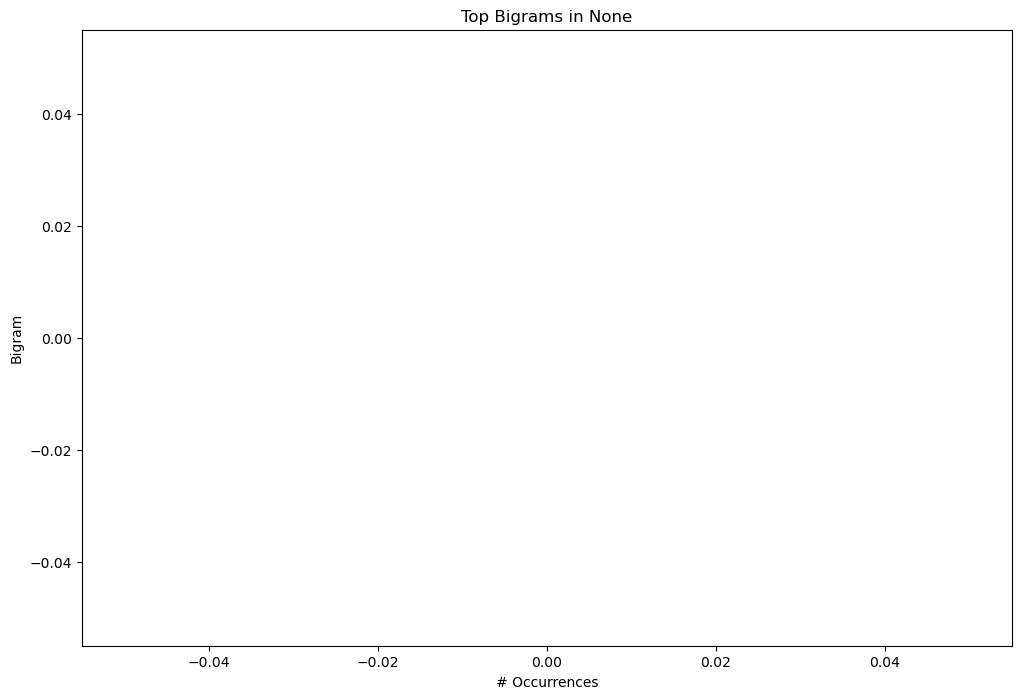

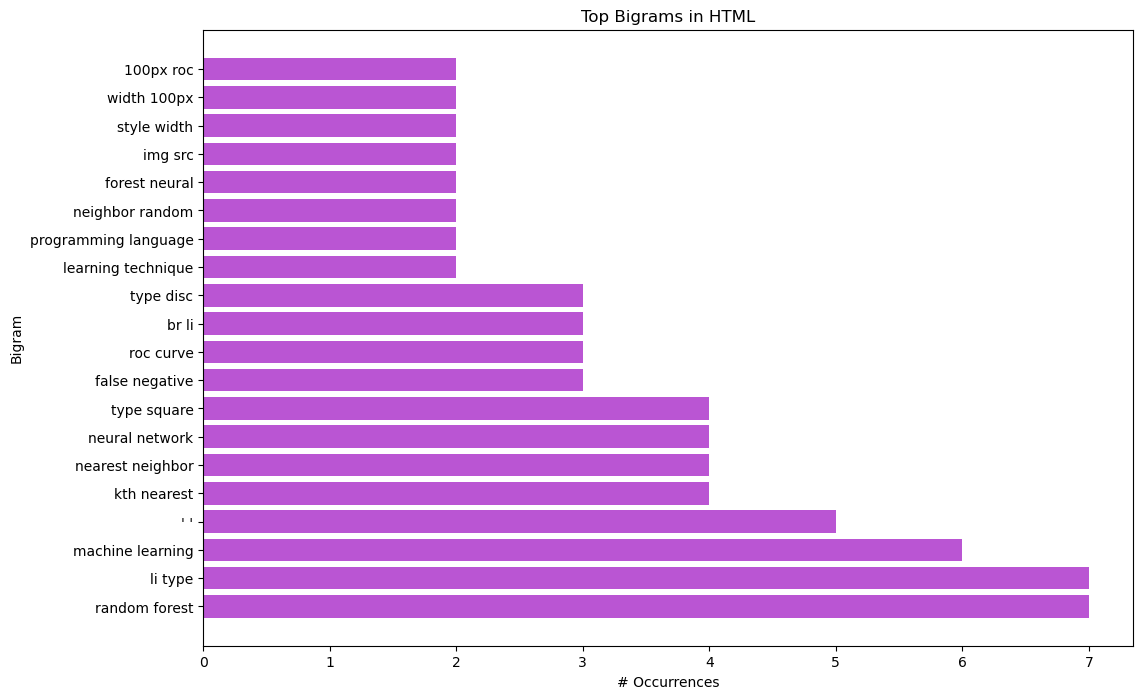

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk.util import bigrams

# Define a function to get the top N bigrams from a list of words
def get_top_bigrams(words, N):
    bigram_list = list(bigrams(words))
    bigram_counts = Counter(bigram_list)
    top_bigrams = bigram_counts.most_common(N)
    return top_bigrams

# Create a dictionary to store the top bigrams for each language
top_bigrams_by_language = {}

# Iterate through each unique language in your DataFrame
for language in df['language'].unique():
    # Filter the DataFrame for the specific language
    language_df = df[df['language'] == language]

    # Combine all tokenized text for the language and split it into words
    words = ' '.join(language_df['clean_norm_token']).split()

    # Get the top 20 bigrams for the language
    top_bigrams = get_top_bigrams(words, 20)

    # Store the top bigrams in the dictionary
    top_bigrams_by_language[language] = top_bigrams

# Create a bigram plot for each language
for language, top_bigrams in top_bigrams_by_language.items():
    bigram_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Count'])
    plt.figure(figsize=(12, 8))
    plt.barh(bigram_df['Bigram'].apply(lambda t: f'{t[0]} {t[1]}'), bigram_df['Count'], color='mediumorchid')
    plt.title(f'Top Bigrams in {language}')
    plt.ylabel('Bigram')
    plt.xlabel('# Occurrences')
    plt.show()


Take aways:

* 'machine learning' has a relationship with other
* 'deep learning' has a relationship with Python
* 'r script' has a relationship with R
* 'li type' has a relationship with HTML

# Trigram

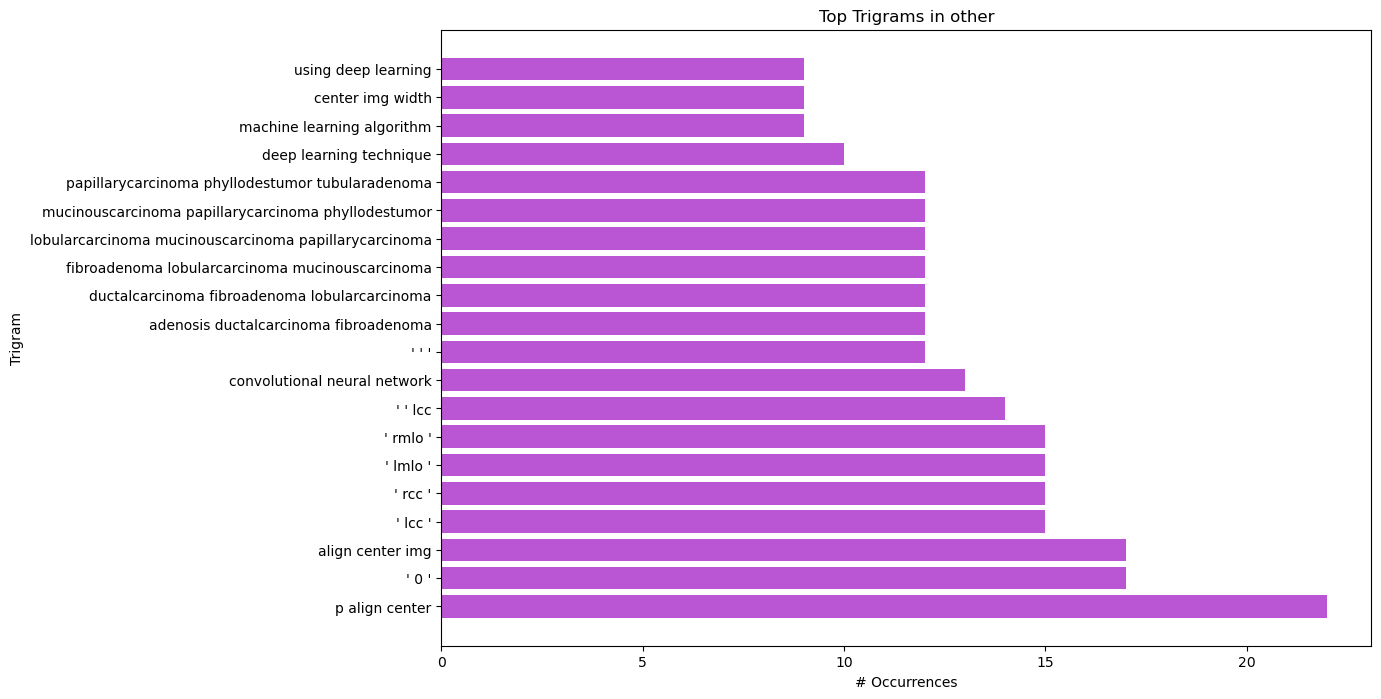

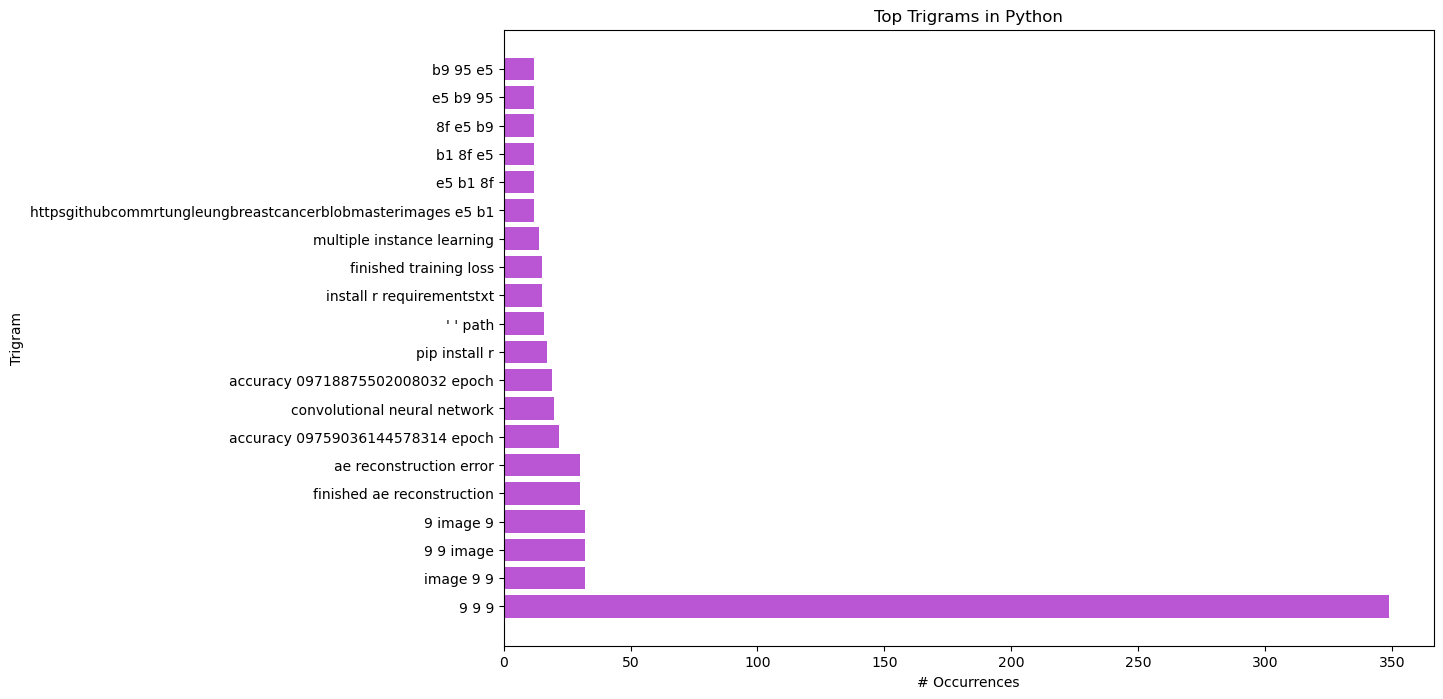

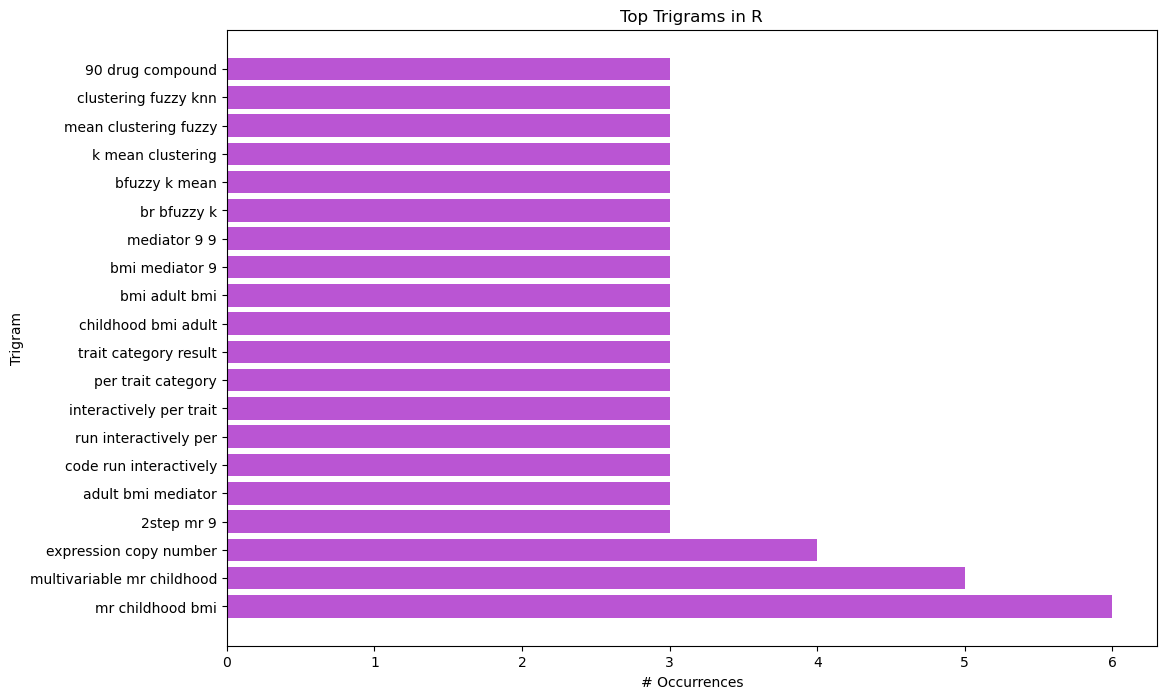

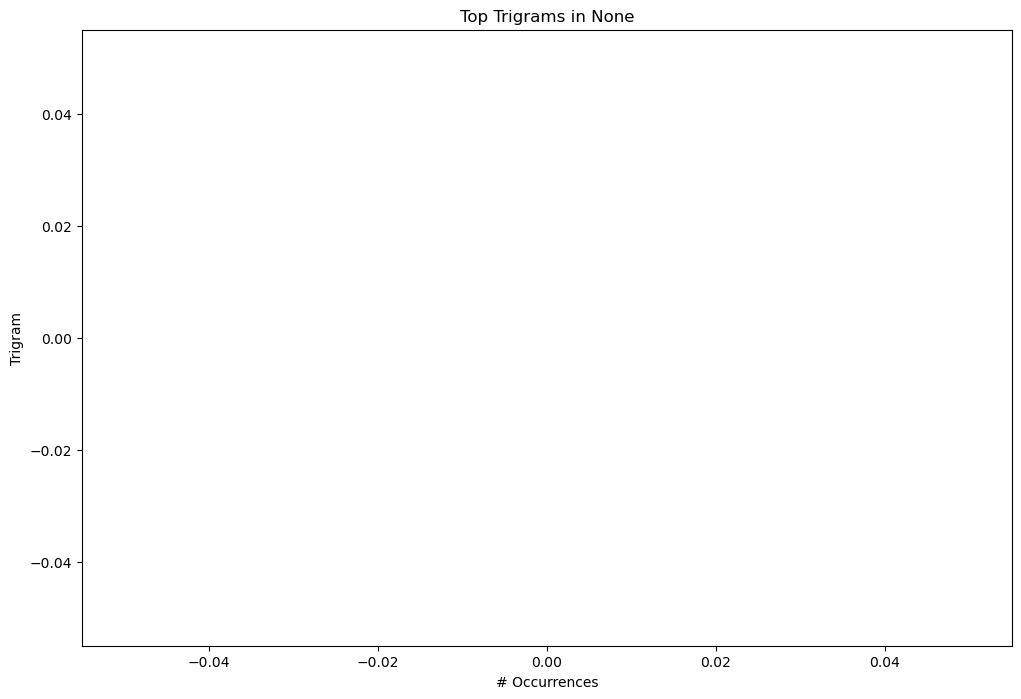

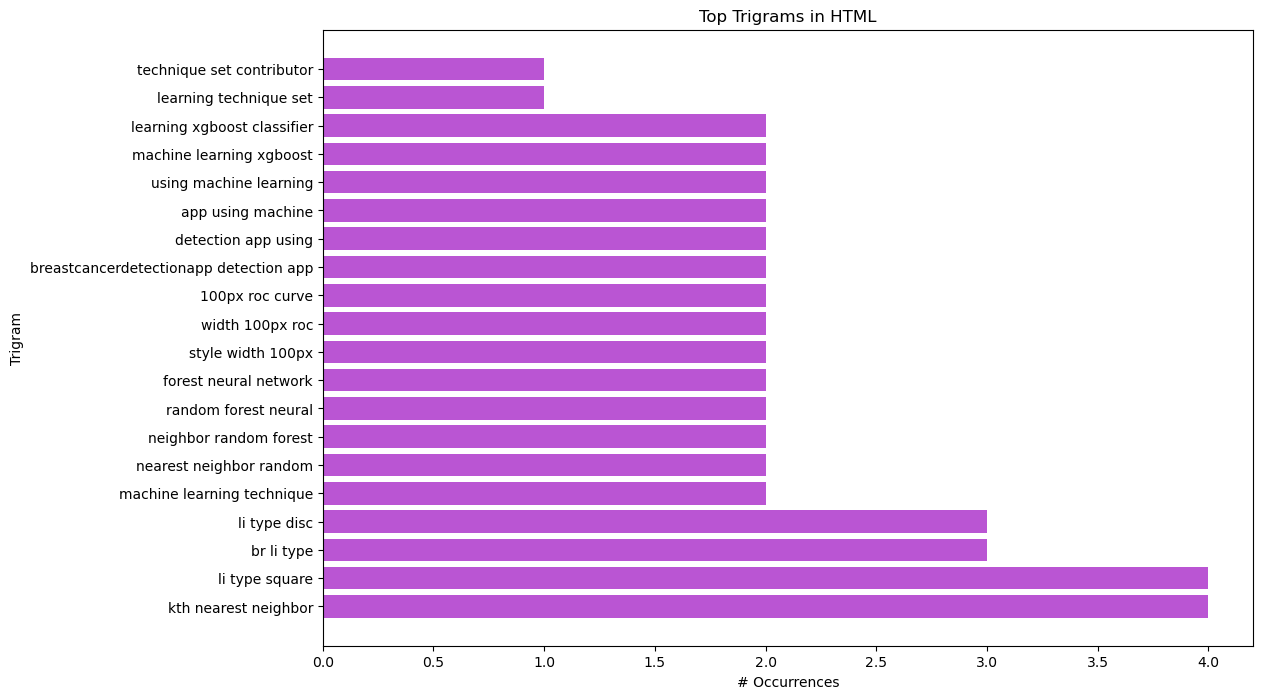

In [36]:
from nltk.util import trigrams

# Define a function to get the top N trigrams from a list of words
def get_top_trigrams(words, N):
    trigram_list = list(trigrams(words))
    trigram_counts = Counter(trigram_list)
    top_trigrams = trigram_counts.most_common(N)
    return top_trigrams

# Create a dictionary to store the top trigrams for each language
top_trigrams_by_language = {}

# Iterate through each unique language in your DataFrame
for language in df['language'].unique():
    # Filter the DataFrame for the specific language
    language_df = df[df['language'] == language]

    # Combine all tokenized text for the language and split it into words
    words = ' '.join(language_df['clean_norm_token']).split()

    # Get the top 20 trigrams for the language
    top_trigrams = get_top_trigrams(words, 20)

    # Store the top trigrams in the dictionary
    top_trigrams_by_language[language] = top_trigrams

# Create a trigram plot for each language
for language, top_trigrams in top_trigrams_by_language.items():
    trigram_df = pd.DataFrame(top_trigrams, columns=['Trigram', 'Count'])
    plt.figure(figsize=(12, 8))
    plt.barh(trigram_df['Trigram'].apply(lambda t: f'{t[0]} {t[1]} {t[2]}'), trigram_df['Count'], color='mediumorchid')
    plt.title(f'Top Trigrams in {language}')
    plt.ylabel('Trigram')
    plt.xlabel('# Occurrences')
    plt.show()


Take aways: 

* '
* 'convolutional neural network' has a relationship with Python
* 'code run interactively' has a relationship with R
* 'style width 100px' has a relationship with HTML

# C Trigram

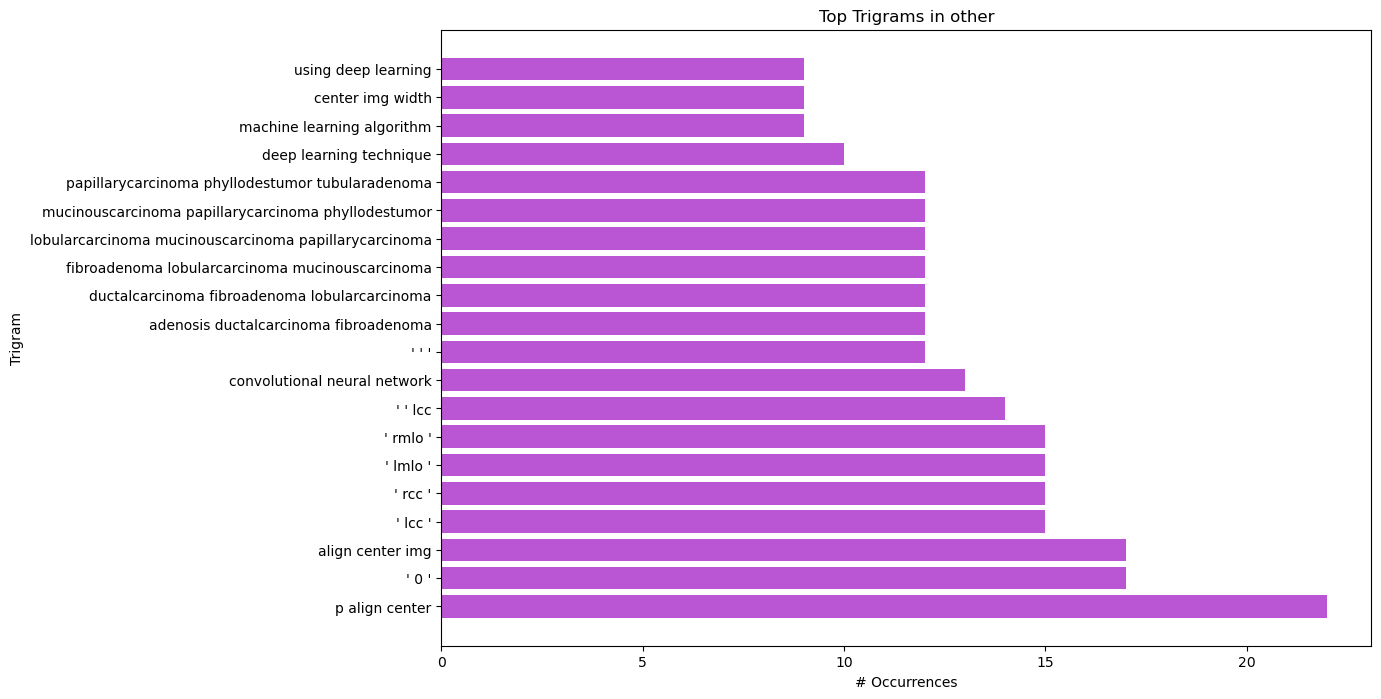

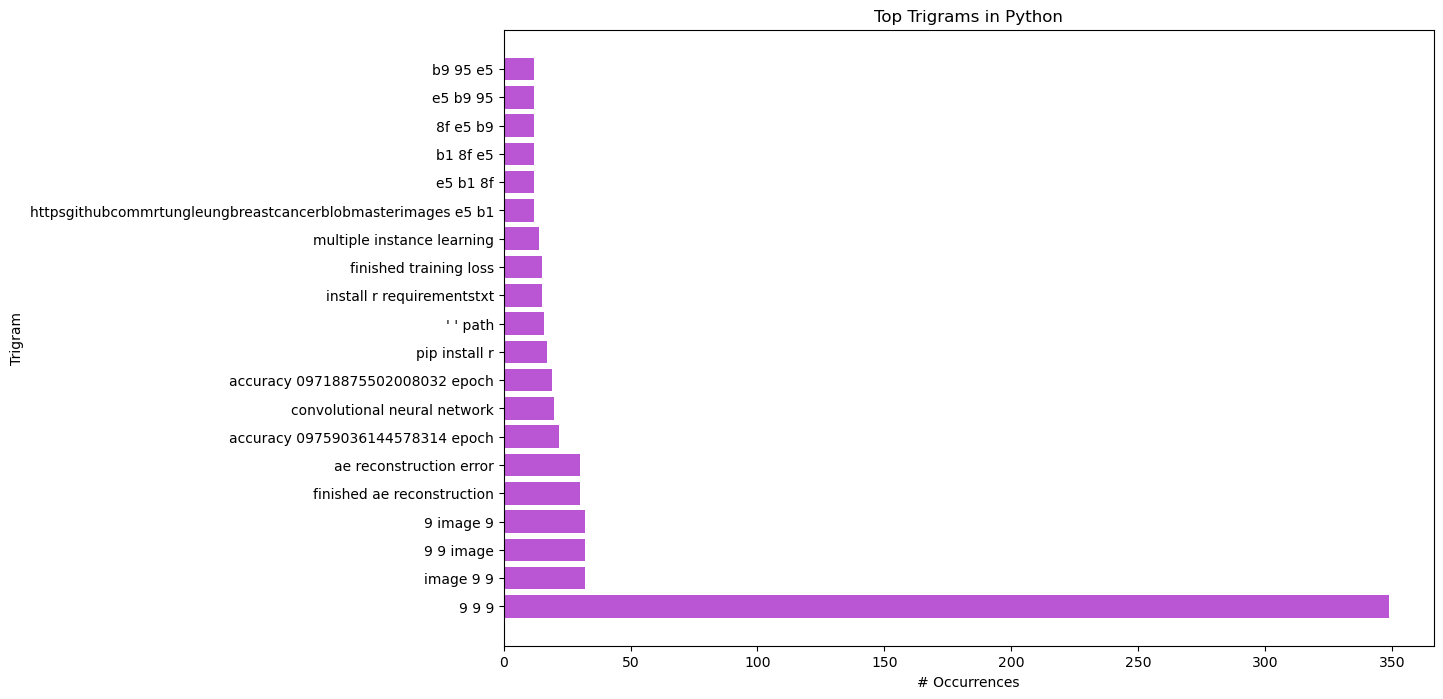

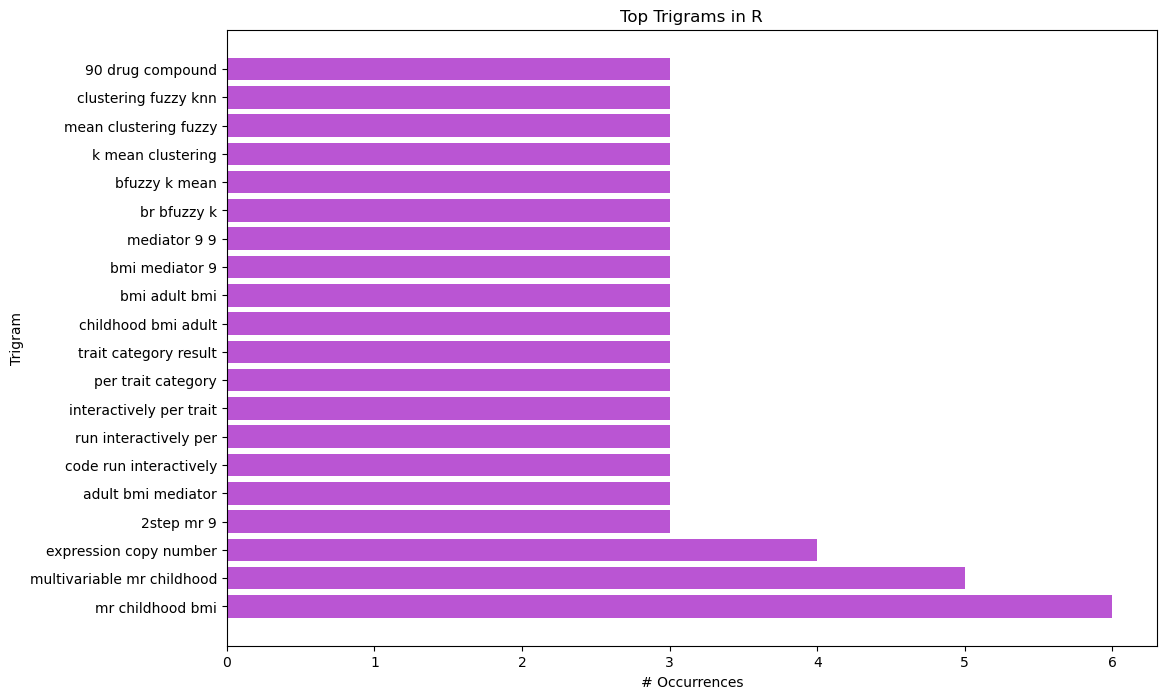

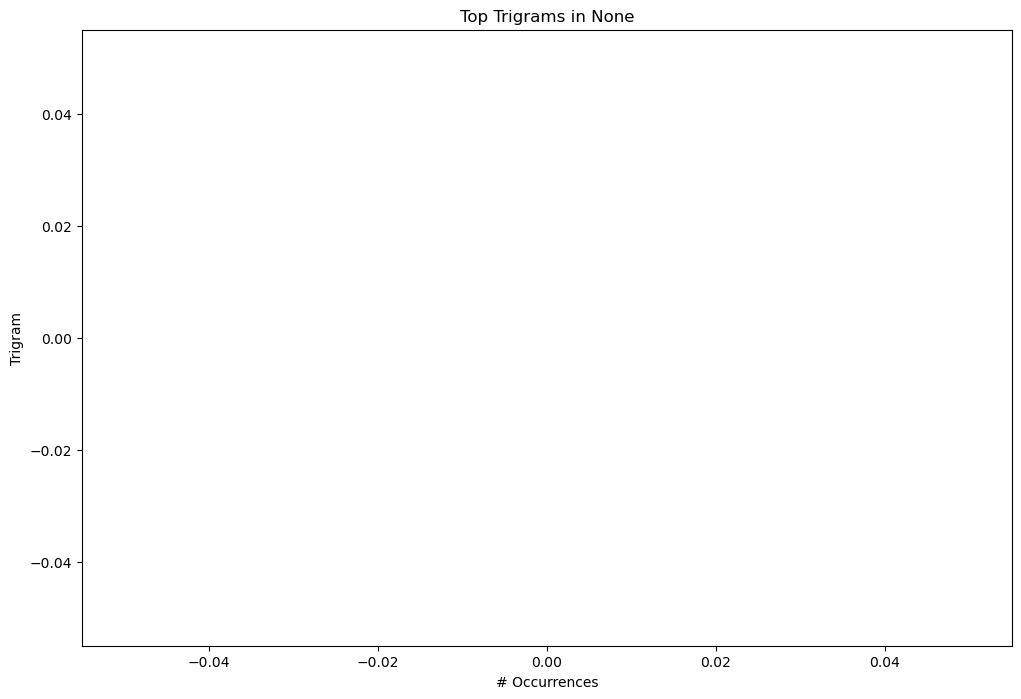

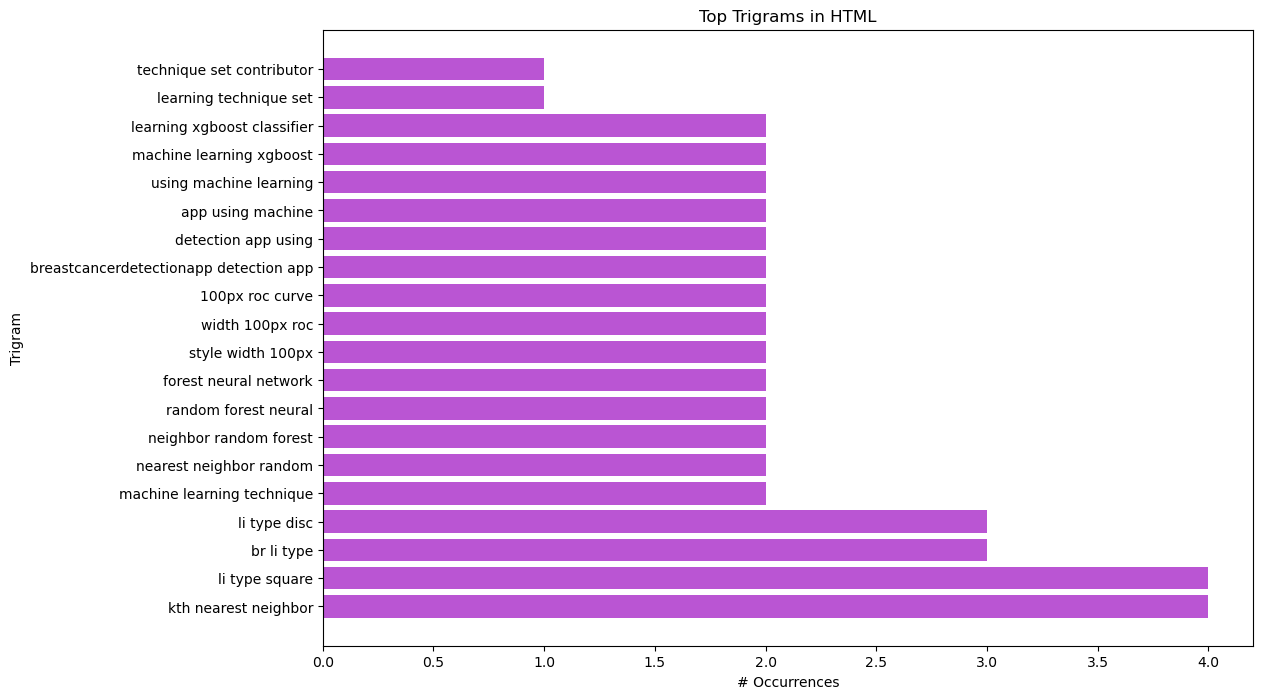

In [38]:
from nltk.util import trigrams

# Define a function to get the top N trigrams from a list of words
def get_top_trigrams(words, N):
    trigram_list = list(trigrams(words))
    trigram_counts = Counter(trigram_list)
    top_trigrams = trigram_counts.most_common(N)
    return top_trigrams

# Create a dictionary to store the top trigrams for each language
top_trigrams_by_language = {}

# Iterate through each unique language in your DataFrame
for language in df['language'].unique():
    # Filter the DataFrame for the specific language
    language_df = df[df['language'] == language]

    # Combine all tokenized text for the language and split it into words
    words = ' '.join(language_df['clean_norm_token']).split()

    # Get the top 20 trigrams for the language
    top_trigrams = get_top_trigrams(words, 20)

    # Store the top trigrams in the dictionary
    top_trigrams_by_language[language] = top_trigrams

# Create a trigram plot for each language
for language, top_trigrams in top_trigrams_by_language.items():
    trigram_df = pd.DataFrame(top_trigrams, columns=['Trigram', 'Count'])
    plt.figure(figsize=(12, 8))
    plt.barh(trigram_df['Trigram'].apply(lambda t: f'{t[0]} {t[1]} {t[2]}'), trigram_df['Count'], color='mediumorchid')
    plt.title(f'Top Trigrams in {language}')
    plt.ylabel('Trigram')
    plt.xlabel('# Occurrences')
    plt.show()


## Explore Takeaways:



# Hypothesis 1


# Hypothesis 2 


# Hypothesis 3


# Hypothesis 4


# Modeling 

In [ ]:
# Assuming 'df' is your DataFrame
df.dropna(subset=['language'], inplace=True)

# Now you can proceed with your train-test split function
train, validate, test = w.split_function_cat_target(df, "language")


# What to do next? 

* to have more time to develop medical terminology libraries to rid of all medical term that pop up in the top 10 words
* if i were to cross examine the words in each columns with the combine word cloud, then i can rid of multiple words 